In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )


In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [100]:
MAX_RATIO = 15


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
def findPositions(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = 255*(gray < 50).astype(np.uint8)  # To invert the text to white
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones((2, 2), dtype=np.uint8))  # Perform noise filtering
    coords = cv2.findNonZero(gray)  # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords)  # Find minimum spanning bounding box
    print( x, y, w, h)
    # Crop the image - note we do this on the original image
    cropped_image = image[y-10:y+h+10, x-10:x+w+10]

    return cropped_image


In [6]:
# Load with pytorch epoch=4-step=17280.ckpt

model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Printed1_2D64_1600_NORM_WHITE.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
scripted = lit_model.to_torchscript()


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


123 48 268 37


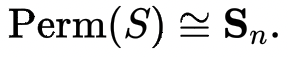

None
(57, 288, 3)
torch.Size([1, 64, 1600])


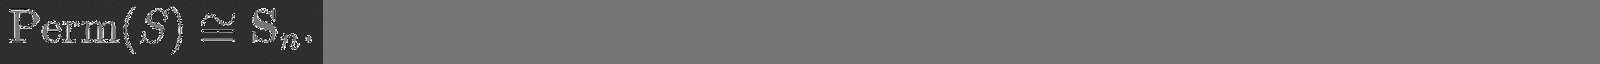

None

Predicted formula:
 <S> \mathrm { ~ T } { \cal R } { \cal I I I } \left( { \cal S } \right) ~ { \frac { { \cal P } } { \longrightarrow } ~ { \cal S } { \cal R } { \bf n } ~ <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [102]:
image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = findPositions(image)
print(display(transform(image)))
print(image.shape)


h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

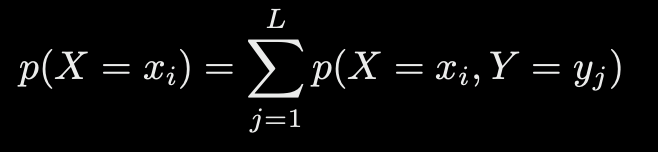

(17, 8) (620, 132)


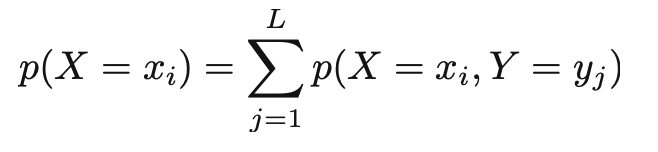

torch.Size([1, 64, 1600])


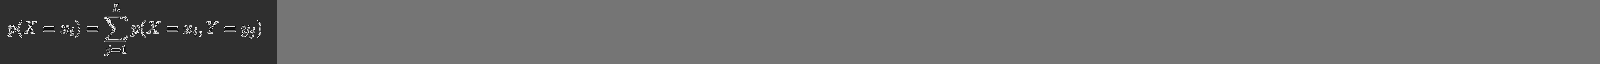

None

Predicted formula:
 <S> \begin{array} { c c } { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } & { } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [8]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = ~image
display(transform(image))
image = findPositions(image)
image= ~image
display(transform(image))
h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(0, 0) (177, 40)
torch.Size([1, 64, 1600])


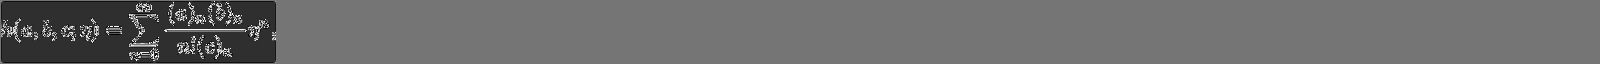

None

Predicted formula:
 <S> l ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [9]:
image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

findPositions(image)
h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(0, 0) (56, 22)
torch.Size([1, 64, 1600])


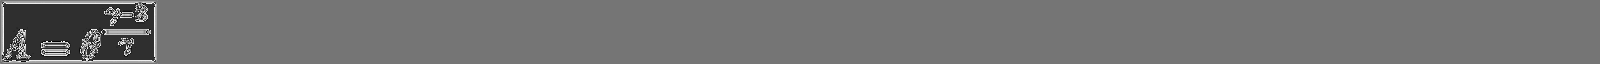

None

Predicted formula:
 <S> A = \theta ^ { \frac { \gamma - 2 } { \gamma } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [10]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

findPositions(image)
h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(0, 0) (811, 383)
torch.Size([1, 64, 1600])


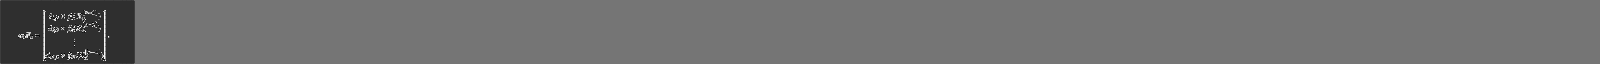

None

Predicted formula:
 <S> \begin{array} { c c } { } & { } & { } \\ { } & { } & { } \\ { } & { } & { } \\ { } & { } & { } & { } \\ { } & { } & { } \\ { } & { } & { } \\ { } & { } & { } \\ { } & { } & { } \\ { } & { } & { } & { } \\ { } & { } & { } \\ { } & { } & { } \\ { } & { } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [11]:

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_11.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

findPositions(image)
h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(0, 0) (1903, 391)
torch.Size([1, 64, 1600])


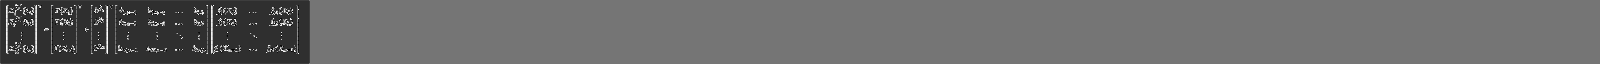

None

Predicted formula:
 <S> \begin{array} { c c c c } { \left[ r _ { 1 } ^ { ( r ) } } \\ { \vdots } & { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } & { \vdots } \\ { \vdots } \\ \end{array} \right] } \\ { \vdots } & { \vdots } \\ { \vdots } \\ \end{array} \right) ^


<IPython.core.display.Math object>

None


In [12]:

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_12.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

findPositions(image)


h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(0, 0) (1079, 319)
torch.Size([1, 64, 1600])


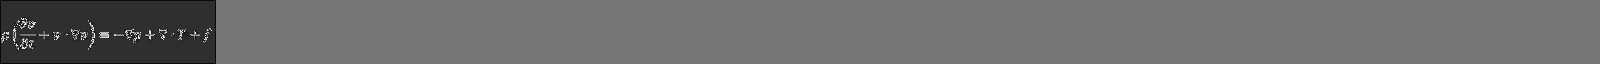

None

Predicted formula:
 <S> \rho \left( \frac { \partial \nu } { \partial t } \cdot v \, \tau _ { \nu } \right) = - \mathrm { T } _ { p } + \mathrm { T } \cdot T \, <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [13]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

findPositions(image)
h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(0, 0) (1423, 199)
torch.Size([1, 64, 1600])


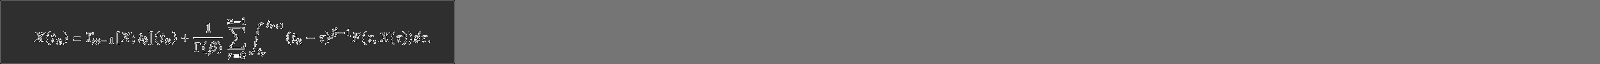

None

Predicted formula:
 <S> \qquad \chi ( t _ { n } ) \approx T _ { m - 1 } ( X _ { i l } ) ( t _ { n } ) ( t ) \, s = \frac { 1 } { \Gamma ( \rho ) } \sum _ { T = 0 } ^ { \prime } \int _ { T = 0 } ^ { L _ { r } } ( t _ { n } - \tau ) ^ { \rho - 1 } F ( \tau , X ( \tau ) d r _ { i } ~ ~ ~ ~ ~ ~ ~ <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [14]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

findPositions(image)
h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(0, 0) (1773, 201)
torch.Size([1, 64, 1600])


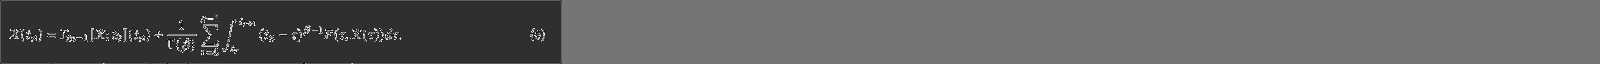

None

Predicted formula:
 <S> \begin{array} { c c c c } { \chi ( r _ { n } ) = T _ { m + 1 } ( X _ { n } ) ( f ) } \\ { \Gamma ( p ) } \sum _ { r = 1 } ^ { r - 1 } \int _ { r _ { r } } ^ { t . } } ( q ) \sum _ { r , n } ^ { p - 1 } r _ { r . } \\ \end{array} ( t _ { s } z ( \tau ) ) d \tau _ { z } \qquad \qquad \qquad \qquad ( q ) } & { <E> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [15]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

findPositions(image)
h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(0, 0) (1949, 187)
torch.Size([1, 64, 1600])


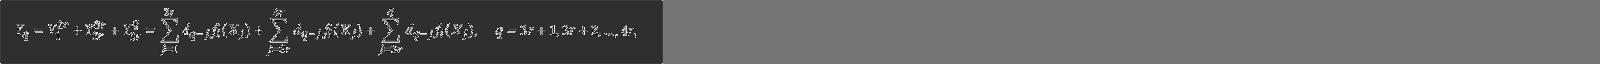

None

Predicted formula:
 <S> \begin{array} { c c c } { Y _ { 1 } ^ { 2 r } \, { \bf ~ Y } _ { p } ^ { 2 r } \, { \bf ~ y } ^ { g } \, { \bf ~ y } } ^ { g } \, { \bf y } _ { p } ^ { g } - \sum _ { p = 1 } ^ { 3 r } d _ { q - I } ( { \cal X } ) \cdot \sum _ { p = 2 } ^ { 3 r } d _ { q + f } ( { \cal X } ) \cdot } \\ \end{array} <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [16]:
image_path=  "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

findPositions(image)

h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))